<a href="https://colab.research.google.com/github/yajima-yasutoshi/DataScience2025/blob/main/20251226/%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#分類

20251226

#本日の講義の目的

分類手法に関する説明を行う。特に、ロジスティック回帰による予測モデルの構築法を理解する。

## 分類手法が活用されるシーン

* 解約、離脱の予測
> 携帯電話や動画配信サービスなどのサブスクリプションサービスでは、
会員数を維持することがビジネス上非常に重要である。
そこで、
将来解約する可能性のある会員に対しては
例えば、クーポンによる割引を実施するなどで
解約をできるだけ防ぐ取り組みが行われます。
分類手法を活用することで、
会員の属性やサービスの利用傾向から
将来解約するかしないかが予測でき、
解約しそうな会員のみに施策を実施することで、
効率よく解約を防ぐ試みが行われている。


* 病気の診断
> 検査の結果や過去の病歴などから病気にかかっているのか/いないのか、
あるいは将来の発病を予測することにデータの活用が盛んに行われている。
近年は画像データを使った予測も行われている。

* 倒産や破産の予測
> 金融機関で融資を行う際には、借り手が返済可能かそうでないかを判断する。
個人向けの融資であれば、個人の属性や年収、職業といったデータが使われ、
あるいは、企業向けの融資であれば、さまざまな財務指標データを使った
予測が広く行われている。

* 不正検知
> クレジットカード利用や金融取引などでは、
正当な利用か不正な利用か判断し、
自動的に利用を制限するシステムが導入されている。
こういったシステムには、
取引に関するデータを使った予測モデルが組み込まれている。

この例のように、ある事象の発生するかしないかを予測する問題を
**2値の分類問題**と呼び、
のそ代表的なAIモデルが**ロジスティック回帰**である。


### 【参考】ロジスティック回帰ライブラリー
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# 環境の準備

まず初めに、日本語を表示するための準備と
分析に必要なライブラリーのインポートを行うため、
以下のセルを実行する。

In [ ]:
# インストール
!pip install japanize-matplotlib

# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# その他必要なライブラリー
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# データの準備

sklearn ライブラリーに格納されている
cancer data と呼ばれるサンプルデータを使い、
ロジスティック回帰の説明を行う。

以下のセルでは、
データを読み込みデータフレーム変数 df に格納
する操作を行っている。

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df['diagnosis'] = cancer.target

データの構造を info() で確認する。

In [ ]:
df.info()

これは、癌の疑いのある細胞に関連した30項目（サイズ、形状、など細胞の状態）の情報と、そこから医師などが判断した診断結果（'diagnosis'）のデータである。

このデータでは全ての項目は数値型となっており、
また、欠損値もないことが確認できる。

特に診断結果（'diagnosis'）は

* 悪性の場合には 0
* 良性の場合には 1

が入力されており、
このような項目を**2値**の項目と呼ぶ。

このデータを学習させて、
細胞に関する30項目を説明変数として
**癌の診断（良性か悪性かの分類）を行うAIを構築**する。

##基礎集計

まず初めに、
目的変数となる diagnosis の分布の確認する。

In [ ]:
plt.figure(figsize=(6, 2))
sns.countplot(y='diagnosis', data=df)

diagnosis は数値型の項目ではあるが、値は 0 と 1 の2値となっており
分類問題の目的変数として用いることができることが確かめられる。

ヒストグラムを作成して、各項目の分布を確認する。

In [ ]:
sns.histplot(data=df, x='mean radius')

hue を使い目的変数（diagnosis）で色分けする。

In [ ]:
sns.histplot(data=df, x='mean radius', hue='diagnosis', kde=True)

このグラフからは、mean radius がおよそ18を超えるとほぼ全てが悪性、
逆に10を下回るとほぼ全てが良性になっていることが分かる。

一方で、10から18の間では、良性も悪性もあり、
この項目だけでは細胞が悪性か良性かを判断できないことが分かる。

In [ ]:
sns.histplot(data=df, x='radius error', hue='diagnosis', kde=True)

In [ ]:
# sns.histplot(data=df, x='fractal dimension error', hue='diagnosis', kde=True)
sns.histplot(data=df, x='mean compactness', hue='diagnosis')

In [ ]:
sns.histplot(data=df, x='mean area', hue='diagnosis')
# sns.boxplot(data=df, y='mean area')

# ロジスティック回帰
30項目の数値データと癌の診断結果（diagnosis）から、
悪性か良性かを分類するAIを構築する。

悪性か良性かといった2値の分類を行いたい場合に用いられる手法として、
最も基本となる**「ロジスティック回帰」**の使い方を説明する。

### ロジスティックモデル構築全体の流れ

ロジスティックモデル構築の流れは以下のようになる。

1. 変数の設定

  説明変数と目的変数を設定する。

2. データの分割

  データ全体を、学習用データと評価用データに分割する。
    train_test_split() を利用する。

3. 説明変数の標準化

  変数の平均を0、分散を1に標準化する。
  StandardScaler の fit() と transform() を使うことで実現される。

4. モデルの学習

   学習用データを用いてモデルを構築する。fit() を使う。

5. 評価用データでモデルの精度を評価

   1. 評価用の説明変数で予測を行う。predict() を使う。
   2. 予測と正解を比較して精度を求める。accuracy_score() を使う。



## 変数の設定

* **目的変数：** 予測の対象となる項目。上のデータでは diagnosis である。
* **説明変数：** 予測する元になる項目。上のデータでは30項目の数値型データがある。

ロジスティック回帰を適用するためには、

* 目的変数が2値の項目（カテゴリ変数、数値型変数どちらでも良い）

かつ

* 説明変数が数値型のデータ

となる必要がある。
上で準備したデータはこの条件を満足している。


説明変数と目的変数の項目を、それぞれ変数 X と y にセットする。

In [ ]:
X = df[ ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension']]
y = df[['diagnosis']]

30項目全てを使うため多くの項目を記述する必要があるが、
以下のようにすることもできる。

In [ ]:
# 項目'diagnosis'は変数dfの最後にある項目なので、「最後の列のみを除く」ことで実現する
X = df.iloc[:,:-1]

あるいは、drop を使うことも可能である。
列削除は以下のように実行する。


In [ ]:
X = df.drop(['diagnosis'], axis=1)

列を削除する場合は
```
axis=1
```
が必要である。

## データの分割

予測モデルの精度を事前に確認するために、以下のように全データを「学習用データ」と「検証用データ」にランダム分け、
学習用データでモデルを構築したのちに、
検証用データで精度
（今回の例では、AIの予測が医師の判断とどの程度一致するか）
を確認することが一般的である。

```
train_test_split
```
を用いると、データを学習用と検証用に分割することができる。



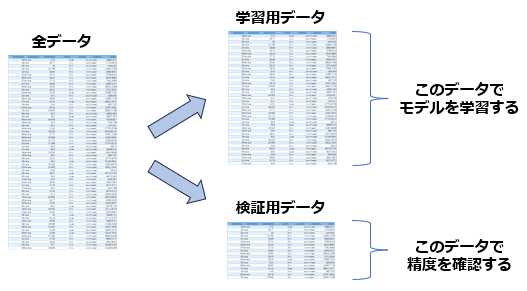

 train_test_split を用いることで、
説明変数 X と目的変数 y から
学習用データと検証用データが作成できる。

```
A, B, C, D  = train_test_split(X, y, test_size=0.2, random_state=0)
```

A, B, C, Dは以下のようにセットされる。

データ | 説明変数  | 目的変数
--     | --        | --
学習用データ | A   | C
検証用データ | B   | D

一般的には検証用のレコード数は、
全体の **2割** から3割程度が適切とされている。
検証用のレコードの割合を2割にする場合は以下のように指定する。
```
test_size=0.2
```

In [ ]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split

# データを学習用データと検証用に分割
# test_size を、0.2 から 0.3 程度が良いとされる
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

shape を使ってレコード数を確認する。

In [ ]:
X.shape

In [ ]:
X_val.shape

検証用データのレコード数が全体の約2割になっていることが確認される。

## 説明変数の標準化

ロジスティック回帰では、説明変数の標準化が必要とされる。

> 標準化とは、データを変換して、平均 0、分散 1 にすることである。

標準化は、
StandardScaler の fit() と transform() を使うことで実現される。

In [ ]:
# 必要なライブラリのインポート
from sklearn.preprocessing import StandardScaler

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train) #学習用のデータで標準化の設定を行う

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled では数値が標準化されたことを確認する。

In [ ]:
# X_train_scaled では数値が標準化されたことを確認する
pd.DataFrame(X_train_scaled, columns=X_train.columns).describe()

mean_redius の平均が

-9.135549e-16

と表示されている。これは、

$-9.135549 \times 10^{-16}$

という意味である。計算誤差の範囲であり 0 と判断する。

いずれの項目も平均が 0、標準偏差が 1.0 になっていることが確認できる。

##ロジスティック回帰モデルの学習

ロジスティック回帰に必要なライブラリーのインポートは
以下のように行う。

```
from sklearn.linear_model import LogisticRegression
```

モデル変数に LogisticRegression() をセットしたのち学習を行う。
学習を行う関数は回帰と同様に fit である。

```
model = LogisticRegression()
model.fit(説明変数, 目的変数)
```



In [ ]:
# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルの準備のための命令
model = LogisticRegression()

# モデルを学習
model.fit(X_train_scaled, y_train)

### 参考

上の例では警告メッセージが表示されるが特に問題はない。
以下のようにプログラムすることで警告メッセージが出力されなくなる。

In [ ]:
# モデルを学習
model.fit(X_train_scaled, y_train.values.ravel()  )

### ロジスティック関数

ロジスティック回帰では、
**ロジスティック関数**を用いて目的変数の値を近似する。

**ロジスティック関数**とは、以下の関数である。
$$ y = \frac{1}{1+ e^{-z}} $$

ただし、
$$ z = a_1 x_1 + a_2 x_2\cdots + a_{30} x_{30} $$
である。

上の $z$ の右辺は重回帰分析で求められた数式と同じ形で、
$x_1, x_2, \ldots, x_{30}$ が30個の変数に対応し、
$a_1, a_2, \ldots, a_{30}$ が回帰係数である。


$z$ を横軸、$y$ を縦軸にとり、ロジスティック関数を可視化した。

In [ ]:
#@title ロジスティック関数の可視化
import numpy as np
import matplotlib.pyplot as plt

def logistic_function(z):
  return 1 / (1 + np.exp(-z))

# zの値を-7から7まで生成
z = np.linspace(-7, 7, 100)

# ロジスティック関数の値を計算
y = logistic_function(z)

# プロット
plt.plot(z, y)
plt.xlabel('z')
plt.ylabel('y')
plt.title('ロジスティック関数')
plt.grid(True)
plt.show()

この図からも分かるように、ロジスティック関数は $z$ を大きくすると  1 、
小さくすると 0 になる関数である。
すなわち、
目的変数が 1 のデータでは z をできるだけ大きく、
目的変数が 0 のデータでは z をできるだけ小さくするように
回帰係数が計算される。

### 回帰係数

線形回帰と同様、回帰係数が model.coef_ により得られる。

In [ ]:
model.coef_

説明変数が30項目あるので、それぞれに対応する回帰係数が得られる。

In [ ]:
sns.barplot(x=model.coef_[0], y=X.columns)

回帰係数には正のものと負のものが計算されていることが分かる。


回帰係数は、

* 正であれば、その項目の値が大きくなれば 1 （このデータの場合では良性）になりやすい、

 逆に

* 負であれば、項目の値が大きくなれば 0 （このデータの場合では悪性）になりやすい、

と解釈ができる。

## 推論

構築したモデルで推論を行うためには、以下のように predict 関数を用いる

```
model.predict(説明変数)
```

predict 関数の内部では z の値が計算され、
0 より大きければ予測結果として 1 が、
そうでなければ 0 が出力される。

評価用として分割したデータに対して予測を行うためには、以下のようにすればよい。

In [ ]:
# 評価データで予測
y_pred = model.predict(X_val_scaled)

学習と同様、説明変数には標準化したものを(X_val_scaled)用いることに注意が必要である。

In [ ]:
y_pred

## 精度の評価

評価用のデータセットを用いて精度の評価を行う。


In [ ]:
#@title 予測と実際の診断結果との比較
compare = y_val.copy()
compare['Pred'] = y_pred
compare

diagnosis と Pred を比べ、
予測(Pred)がデータ（医師の判断）と一致していれば
正しく予測できたことになる。

評価基準としては正解率を用いる。

正解率は全体に対する正解したデータ数の割合である。

In [ ]:
from sklearn.metrics import accuracy_score

# 評価データで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
accuracy

### 混同行列を使った予測精度の確認

混同行列（confusion matrix）とは、正しく予測できたレコード数や正しく予測できなかったレコード数を集計した、以下のような2行2列の表のことである。


 混同行列   | 0 と予測  | 1 と予測
 -- | --        | --
 正解が 0 のデータ |  A   | B
 正解が 1 のデータ |  C   | D

* A は、0 と予測したレコードの中で正解も 0 であったレコード数
* C は、0 と予測したレコードの中で正解は 1 であったレコード数
* B は、1 と予測したレコードの中で正解は 0 であったレコード数
* D は、1 と予測したレコードの中で正解も 1 であったレコード数

A と D の合計が正しく予測できたレコード数となる。

検証用データの場合で、混同行列を作成する。

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

したがって、正解率は以下のように計算できる。

（45+65）÷（45+2+2+65）= 0.9649...



---



---



---



---



# 分類手法の復習のための課題

次週までの課題として、
今回説明したロジスティック回帰を以下のデータに対して実行する。

## Titanic データ

Titanic データとは、
1912年に起きたTitanic号の沈没事故に関するデータで、
乗客の属性と事故で生存したのか死亡したのかが記録されているものである。

ここで利用するデータは、seaborn パッケージにサンプルとして含まれているものである。
データは、以下のように読み込むことができる。

In [ ]:
# データを読み込む
# 変数名を data とした
data = sns.load_dataset("titanic") #タイタニックのデータ

データの概要を info を使い確認する。

In [ ]:
data.info()

レコード数が 891 、項目数が 15 となっている。また、欠損値を含む項目も複数あることが確認できる。

##項目の説明

このデータの各項目の意味は以下の通りである。

列名 | 意味
---  | ---
survived	| 生存フラグ（0=死亡、1=生存）
pclass	| チケットクラス（1stクラス、2ndクラス、3rdクラス）
sex	| 性別（male=男性、female＝女性）
sge	| 年齢
sibsp	| タイタニックに同乗している兄弟/配偶者の数
parch	| タイタニックに同乗している親/子供の数
fare	| 料金
embarked	| 出港地（タイタニックへ乗った港）(C=Cherbourg、Q=Queenstown、S=Southampton)
class | 乗船クラス
who |男性 or 女性
adult_male | 成人男性であるかどうか
deck | 乗船していたデッキ
embark_town | 出港地
alive | 生存したかどうか
alone | 一人であったかどうか

### 欠損値の確認

以下のセルを実行することで、列ごとに欠損値となるレコード数を求める。

In [ ]:
# 欠損値を確認する
data.isnull().sum()

age, embarked, embark_town, deck に欠損値が含まれている。

欠損値に対しては、以下の処理を行う。
* 数値型の項目: 欠損値を平均値で置き換え
* カテゴリ型の項目: 欠損値を最頻値で置き換え

ただし、deck は欠測値が多いので、この項目は分析には用いないことにする。

In [ ]:
# 平均値で欠損値を埋める。
data['age'] = data['age'].fillna(data['age'].mean())

# 最頻値で欠損値を埋める。
data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
data['embark_town'] =  data['embark_town'].fillna(data['embark_town'].mode()[0])

In [ ]:
# 結果を確認
data.isnull().sum()

## 生存する乗客の分類

データクレンジングを行ったデータを使い
乗客の生存、すなわち
項目 'survived' が 0 となるか 1 となるかを予測する分類モデルを構築してみる。

### 数値型の項目のみによるモデル構築

まず、数値型の項目である以下の4項目

 'age', 'fare', 'sibsp', 'parch'

を説明変数、'survived' を目的変数としたロジスティック回帰モデルを構築する。
すなわち、以下のように変数 X と y を設定する。




In [ ]:
# 説明変数と目的変数を選択
# 数値データのみで予測
X = data[[ 'age', 'fare', 'sibsp', 'parch']]
y = data['survived']

なお、以下のようにデータを分割した上で、
学習用データでモデルを作成し検証用データで精度を評価する。
また、得られたモデルの回帰係数も確認してみる。

In [ ]:
# データを学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### カテゴリ型の項目も含めたモデル構築

さらに、カテゴリ変数として、
'embarked', 'class', 'who', 'adult_male', 'alone'
を追加した場合でモデルを作り、精度を評価してみる。


In [ ]:
# カテゴリ変数をOne Hot Encoding
data_encoded = pd.get_dummies(data[['embarked', 'class', 'who', 'adult_male', 'alone']], drop_first=True)

# 説明変数と目的変数を設定
X = pd.concat([data[['age', 'fare', 'sibsp', 'parch']], data_encoded], axis=1)
y = data['survived']

---
---
---


# 発展的な課題

インターネット上には分類問題の学習に適したデータが
数多く提供されています。
例えば、以下のサイトにあるデータを使い、
各自で分類を行うモデルを作成してみよ。

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset